In [1]:
import numpy as np
import pandas as pd

In [3]:
# This may take a long time, since TensorFlow has to load the dataset from disk!
groundtruth_positions = []
timestamp_index_map = dict()
csi_data = []

for index, data in enumerate(training_set):
	csi_data.append(data[0].numpy())
	groundtruth_positions.append(data[1].numpy())
	timestamp_index_map[data[2].numpy()] = index

timestamp_index_map = dict(sorted(timestamp_index_map.items()))
groundtruth_positions = np.asarray(groundtruth_positions)

NameError: name 'training_set' is not defined

In [2]:
meta_data = pd.DataFrame(csi_data)
meta_data['time'] = list(timestamp_index_map.keys())
meta_data[['x', 'y']] = groundtruth_positions

NameError: name 'csi_data' is not defined

In [71]:
meta_data.to_csv('./data/Opendata_3.csv')

# Triplet Mining

In [4]:
from offline_mining_tools import *

In [5]:
meta_data = pd.read_csv('./data/dichasus.csv')
# meta_data = pd.read_csv('./data/Opendata_3.csv')
csi_cols = [col for col in meta_data.columns if col not in ['Unnamed: 0', 'time', 'x', 'y']]
csi_data = meta_data[csi_cols].values
locations = meta_data[['x', 'y']].values

In [6]:
def ap_indices_fabrication(pos_data, d=.3):
    ap_indices = dict()
    meta_tree = spatial.cKDTree(pos_data)
    for i in range(len(pos_data)):
        proximal_index = meta_tree.query_ball_point(pos_data[i], d)
        if len(proximal_index) > 10:
            ap_indices[i] = np.random.choice(proximal_index, 10)
        else:
            ap_indices = proximal_index

    return ap_indices

def triplet_fabrication_with_distance(csi_data, pos_data, d, num_triplets=15000):
    ap_indices = ap_indices_fabrication(pos_data, d)

    triplets_by_distance = []
    anchor_indices = list(ap_indices.keys())
    n_sample = len(anchor_indices)

    ap_dists = []
    an_dists = []

    while len(triplets_by_distance) < num_triplets:
        anchor_indice = np.random.choice(anchor_indices)
        pos_indices = ap_indices[anchor_indice]
        if len(pos_indices) < 1:
            continue
        pos_indice = np.random.choice(pos_indices)
        neg_indice = np.random.randint(n_sample)

        triplets_by_distance.append((csi_data[anchor_indice], csi_data[pos_indice], csi_data[neg_indice]))
        ap_dist = np.linalg.norm(pos_data[anchor_indice] - pos_data[pos_indice])
        an_dist = np.linalg.norm(pos_data[anchor_indice] - pos_data[neg_indice])

        ap_dists.append(ap_dist)
        an_dists.append(an_dist)
    return np.array(triplets_by_distance), ap_dists, an_dists

In [8]:
opendata_3_triplets, ap, an = triplet_fabrication_with_distance(csi_data, locations, d=.4, num_triplets=15000)

In [9]:
triplets_dist_time = np.load('./data/triplets_time_ap_an_dist.npy', allow_pickle=True).item()

In [37]:
opendata_triplets = np.load('/home/ids/yukliu/OpenTest/data/opendata_triplets_by_distance_05.npy')


In [55]:
np.save('./data/opendata_triplets_by_distance_03', opendata_triplets)

In [39]:
np.shape(opendata_3_triplets)

(15000, 3, 1024)

In [38]:
np.shape(opendata_triplets)

(15000, 3, 1024)

In [10]:
df_distance = pd.DataFrame({'ap': ap, 'an':an})
df_time = pd.DataFrame({'ap': triplets_dist_time['ap'], 'an': triplets_dist_time['an']})

In [46]:
df_distance.describe()

,ap,an
count,15000.000000,15000.000000
mean,0.253415,5.317621
std,0.104427,2.925776
min,0.000000,0.011393
25%,0.178324,2.974757
50%,0.271951,4.960346
75%,0.341539,7.446529
max,0.399988,14.818893


In [48]:
df_time.describe()

,ap,an
count,15000.000000,15000.000000
mean,0.176819,5.264758
std,0.120058,2.930019
min,0.000000,0.000000
25%,0.071568,2.889634
50%,0.167840,4.865357
75%,0.270106,7.414309
max,0.882187,14.722218


In [15]:
import seaborn as sns

<Axes: ylabel='Count'>

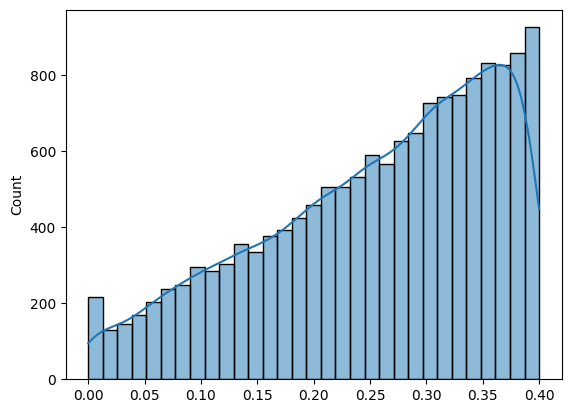

In [20]:
sns.histplot(ap, kde=True)

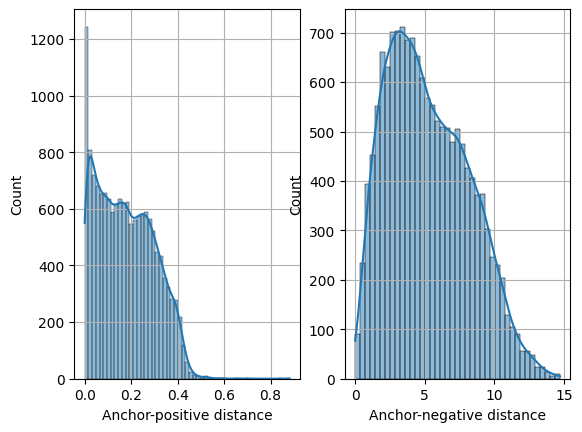

In [35]:
fig, axs = plt.subplots(1,2)
sns.histplot(triplets_dist_time['ap'], kde=True, ax=axs[0])
axs[0].set_xlabel('Anchor-positive distance')
axs[0].grid()
sns.histplot(triplets_dist_time['an'], kde=True, ax=axs[1])
axs[1].set_xlabel('Anchor-negative distance')
plt.grid()
plt.savefig('./result/anp_distance_distribution.pdf')

<Axes: ylabel='Count'>

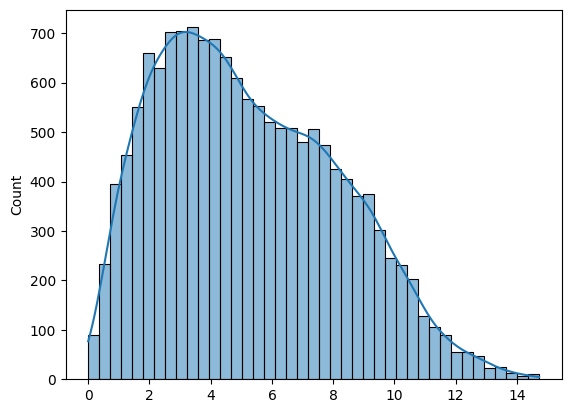

In [28]:
sns.histplot(triplets_dist_time['an'], kde=True)

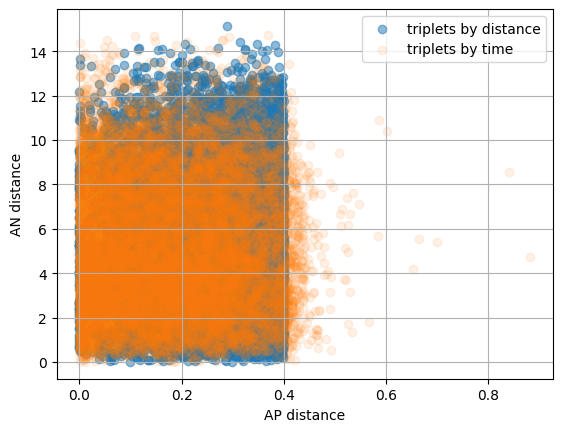

In [12]:
plt.scatter(ap, an, alpha=.5, label='triplets by distance')
plt.scatter(triplets_dist_time['ap'], triplets_dist_time['an'], alpha=.1,label='triplets by time')

plt.xlabel('AP distance')
plt.ylabel('AN distance')
plt.legend()
plt.grid()
plt.savefig('./result/ap_an_distance_compare.pdf')

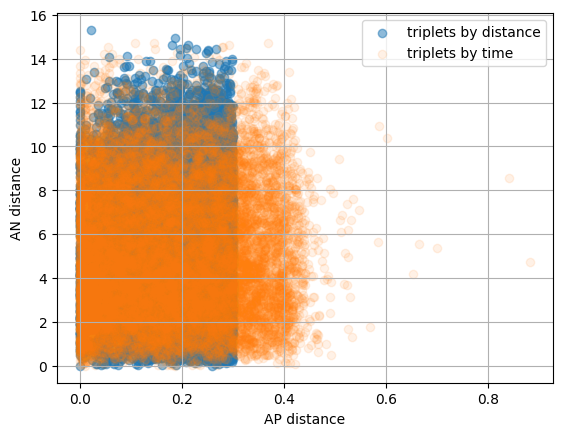

In [28]:
plt.scatter(ap, an, alpha=.5, label='triplets by distance')
plt.scatter(triplets_dist_time['ap'], triplets_dist_time['an'], alpha=.1,label='triplets by time')

plt.xlabel('AP distance')
plt.ylabel('AN distance')
plt.legend()
plt.grid()
# plt.savefig('./result/triplets_sample_distance_compare.pdf')

In [75]:
np.save('./data/opendata_triplets_3', opendata_3_triplets)

In [ ]:
ap_lookup = ap_indices_fabrication(groundtruth_positions)